In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from iterative_pruning import IterativePruning

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
NUM_CHANNELS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 1000
IMAGE_SIZE = [28, 28]
LR = 1.2e-3

In [4]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

X_train = train_subset.dataset.data[train_subset.indices]
y_train = train_subset.dataset.targets[train_subset.indices]

X_val = val_subset.dataset.data[val_subset.indices]
y_val = val_subset.dataset.targets[val_subset.indices]

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

Ime zbirke:     MNIST
Velikost učne množice:   60000
Velikost testne množice:   10000
Dimenzija slik: (1, 28, 28)


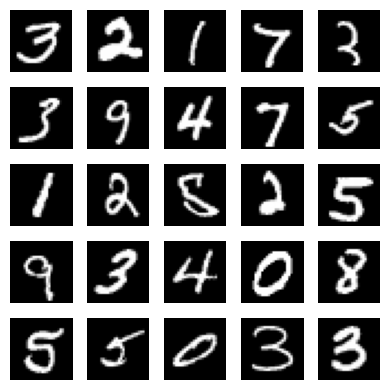

In [5]:
images, _ = next(iter(train_loader))

print(f"Ime zbirke:     MNIST")
print(f"Velikost učne množice:   {len(mnist_trainset)}")
print(f"Velikost testne množice:   {len(mnist_testset)}")
print(f"Dimenzija slik: {images[0].numpy().shape}")

_, axes = plt.subplots(5, 5, figsize=(4, 4), squeeze=False)
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(images[5*i+j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [6]:
model = LeNet300(NUM_CHANNELS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

print(torchinfo.summary(model, (BATCH_SIZE, 1, IMAGE_SIZE[1], IMAGE_SIZE[0])))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet300                                 [128, 10]                 --
├─Linear: 1-1                            [128, 300]                235,500
├─ReLU: 1-2                              [128, 300]                --
├─Linear: 1-3                            [128, 100]                30,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 34.13
Input size (MB): 0.40
Forward/backward pass size (MB): 0.42
Params size (MB): 1.07
Estimated Total Size (MB): 1.89


In [7]:
for i, data in enumerate(model.named_parameters()):
    name, param = data
    if "weight" in name:
        print(name)
        print(np.shape(param.data))

linear_1.weight
torch.Size([300, 784])
linear_2.weight
torch.Size([100, 300])
linear_3.weight
torch.Size([10, 100])


In [8]:
ip = IterativePruning(model)

acc, sp = ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS, 2, 0, 0.2)
torch.save(model, "model_lenet_mnist.pt")

391it [00:09, 40.09it/s]                         
79it [00:01, 48.34it/s]                        


Epoch: 1/1000, loss: 0.3453, val_loss: 0.1707


391it [00:08, 46.48it/s]                         
79it [00:01, 51.64it/s]                        


Epoch: 2/1000, loss: 0.1292, val_loss: 0.1135


391it [00:08, 46.38it/s]                         
79it [00:01, 50.42it/s]                        


Epoch: 3/1000, loss: 0.0840, val_loss: 0.0913


391it [00:08, 46.35it/s]                         
79it [00:01, 51.93it/s]                        


Epoch: 4/1000, loss: 0.0613, val_loss: 0.0915


391it [00:08, 47.34it/s]                         
79it [00:01, 52.10it/s]                        


Epoch: 5/1000, loss: 0.0447, val_loss: 0.0852


391it [00:08, 45.87it/s]                         
79it [00:01, 46.81it/s]                        


Epoch: 6/1000, loss: 0.0331, val_loss: 0.0864


391it [00:09, 40.55it/s]                         
79it [00:02, 38.14it/s]                        


Epoch: 7/1000, loss: 0.0263, val_loss: 0.0853
Training has ended due to early stoppage at epoch 7.


79it [00:02, 28.30it/s]                        


Točnost: 0.976, Redkost: 1.000 



0.2
0.2
0.1


391it [00:08, 46.69it/s]                         
79it [00:01, 51.00it/s]                        


Epoch: 1/1000, loss: 0.3314, val_loss: 0.1619


391it [00:09, 42.97it/s]                         
79it [00:02, 37.31it/s]                        


Epoch: 2/1000, loss: 0.1203, val_loss: 0.1138


391it [00:08, 45.99it/s]                         
79it [00:01, 48.57it/s]                        


Epoch: 3/1000, loss: 0.0773, val_loss: 0.0974


391it [00:09, 42.57it/s]                         
79it [00:02, 35.87it/s]                        


Epoch: 4/1000, loss: 0.0547, val_loss: 0.0842


391it [00:08, 44.08it/s]                         
79it [00:01, 49.14it/s]                        


Epoch: 5/1000, loss: 0.0401, val_loss: 0.0777


391it [00:08, 45.30it/s]                         
79it [00:01, 44.10it/s]                        


Epoch: 6/1000, loss: 0.0308, val_loss: 0.0772


391it [00:09, 39.52it/s]                         
79it [00:01, 46.13it/s]                        


Epoch: 7/1000, loss: 0.0228, val_loss: 0.0989


391it [00:09, 41.50it/s]                         
79it [00:01, 46.26it/s]                        


Epoch: 8/1000, loss: 0.0201, val_loss: 0.0804
Training has ended due to early stoppage at epoch 8.


79it [00:02, 29.61it/s]                        


Točnost: 0.980, Redkost: 0.800 



0.2
0.2
0.1


391it [00:09, 43.01it/s]                         
79it [00:01, 42.69it/s]                        


Epoch: 1/1000, loss: 0.3225, val_loss: 0.1525


391it [00:09, 41.66it/s]                         
79it [00:01, 49.66it/s]                        


Epoch: 2/1000, loss: 0.1076, val_loss: 0.1037


391it [00:09, 42.99it/s]                         
79it [00:01, 47.09it/s]                        


Epoch: 3/1000, loss: 0.0652, val_loss: 0.0854


391it [00:08, 46.28it/s]                         
79it [00:01, 49.51it/s]                        


Epoch: 4/1000, loss: 0.0428, val_loss: 0.0818


391it [00:08, 45.61it/s]                         
79it [00:01, 49.75it/s]                        


Epoch: 5/1000, loss: 0.0316, val_loss: 0.0750


391it [00:08, 45.50it/s]                         
79it [00:01, 47.42it/s]                        


Epoch: 6/1000, loss: 0.0237, val_loss: 0.0823


391it [00:08, 45.81it/s]                         
79it [00:01, 51.61it/s]                        


Epoch: 7/1000, loss: 0.0170, val_loss: 0.0781
Training has ended due to early stoppage at epoch 7.


79it [00:02, 32.91it/s]                        


Točnost: 0.979, Redkost: 0.640 



0.2
0.2
0.1


391it [00:08, 45.68it/s]                         
79it [00:01, 47.63it/s]                        


Epoch: 1/1000, loss: 0.3117, val_loss: 0.1458


391it [00:08, 44.24it/s]                         
79it [00:01, 46.91it/s]                        


Epoch: 2/1000, loss: 0.0935, val_loss: 0.0961


391it [00:08, 44.36it/s]                         
79it [00:01, 45.72it/s]                        


Epoch: 3/1000, loss: 0.0553, val_loss: 0.0768


391it [00:09, 40.99it/s]                         
79it [00:01, 43.62it/s]                        


Epoch: 4/1000, loss: 0.0367, val_loss: 0.0773


391it [00:08, 43.65it/s]                         
79it [00:01, 49.60it/s]                        


Epoch: 5/1000, loss: 0.0257, val_loss: 0.0783
Training has ended due to early stoppage at epoch 5.


79it [00:02, 33.19it/s]                        


Točnost: 0.976, Redkost: 0.512 



0.2
0.2
0.1


391it [00:08, 45.46it/s]                         
79it [00:01, 47.24it/s]                        


Epoch: 1/1000, loss: 0.3071, val_loss: 0.1315


391it [00:08, 43.62it/s]                         
79it [00:01, 47.19it/s]                        


Epoch: 2/1000, loss: 0.0849, val_loss: 0.1065


391it [00:09, 43.01it/s]                         
79it [00:01, 44.07it/s]                        


Epoch: 3/1000, loss: 0.0510, val_loss: 0.0786


391it [00:09, 43.21it/s]                         
79it [00:01, 46.23it/s]                        


Epoch: 4/1000, loss: 0.0330, val_loss: 0.0782


391it [00:08, 44.76it/s]                         
79it [00:01, 50.66it/s]                        


Epoch: 5/1000, loss: 0.0236, val_loss: 0.0771


391it [00:09, 40.51it/s]                         
79it [00:02, 37.26it/s]                        


Epoch: 6/1000, loss: 0.0170, val_loss: 0.0818


391it [00:10, 39.01it/s]                         
79it [00:01, 48.18it/s]                        


Epoch: 7/1000, loss: 0.0132, val_loss: 0.0855
Training has ended due to early stoppage at epoch 7.


79it [00:02, 34.37it/s]                        


Točnost: 0.980, Redkost: 0.410 



0.2
0.2
0.1


391it [00:08, 43.77it/s]                         
79it [00:01, 39.59it/s]                        


Epoch: 1/1000, loss: 0.3140, val_loss: 0.1308


391it [00:10, 37.79it/s]                         
79it [00:01, 47.72it/s]                        


Epoch: 2/1000, loss: 0.0810, val_loss: 0.0922


391it [00:08, 44.08it/s]                         
79it [00:01, 49.45it/s]                        


Epoch: 3/1000, loss: 0.0465, val_loss: 0.0752


391it [00:09, 41.63it/s]                         
79it [00:02, 39.16it/s]                        


Epoch: 4/1000, loss: 0.0304, val_loss: 0.0746


391it [00:09, 41.09it/s]                         
79it [00:01, 44.49it/s]                        


Epoch: 5/1000, loss: 0.0210, val_loss: 0.0771


391it [00:09, 41.26it/s]                         
79it [00:01, 46.15it/s]                        


Epoch: 6/1000, loss: 0.0151, val_loss: 0.0800
Training has ended due to early stoppage at epoch 6.


79it [00:02, 30.53it/s]                        


Točnost: 0.980, Redkost: 0.328 



0.2
0.2
0.1


391it [00:08, 44.30it/s]                         
79it [00:01, 44.50it/s]                        


Epoch: 1/1000, loss: 0.3275, val_loss: 0.1240


391it [00:08, 45.30it/s]                         
79it [00:01, 49.94it/s]                        


Epoch: 2/1000, loss: 0.0778, val_loss: 0.0862


391it [00:08, 44.78it/s]                         
79it [00:01, 51.00it/s]                        


Epoch: 3/1000, loss: 0.0458, val_loss: 0.0776


391it [00:08, 45.71it/s]                         
79it [00:01, 49.45it/s]                        


Epoch: 4/1000, loss: 0.0293, val_loss: 0.0726


391it [00:08, 44.43it/s]                         
79it [00:01, 45.37it/s]                        


Epoch: 5/1000, loss: 0.0201, val_loss: 0.0739


391it [00:08, 45.29it/s]                         
79it [00:01, 45.79it/s]                        


Epoch: 6/1000, loss: 0.0151, val_loss: 0.0712


391it [00:08, 43.83it/s]                         
79it [00:01, 46.19it/s]                        


Epoch: 7/1000, loss: 0.0111, val_loss: 0.0816


391it [00:08, 44.38it/s]                         
79it [00:01, 50.51it/s]                        


Epoch: 8/1000, loss: 0.0086, val_loss: 0.0798
Training has ended due to early stoppage at epoch 8.


79it [00:02, 35.70it/s]                        


Točnost: 0.980, Redkost: 0.262 



0.2
0.2
0.1


391it [00:08, 46.56it/s]                         
79it [00:01, 51.72it/s]                        


Epoch: 1/1000, loss: 0.3557, val_loss: 0.1245


391it [00:08, 47.56it/s]                         
79it [00:01, 51.46it/s]                        


Epoch: 2/1000, loss: 0.0776, val_loss: 0.0869


391it [00:08, 47.39it/s]                         
79it [00:01, 52.49it/s]                        


Epoch: 3/1000, loss: 0.0448, val_loss: 0.0751


391it [00:08, 48.34it/s]                         
79it [00:01, 49.69it/s]                        


Epoch: 4/1000, loss: 0.0287, val_loss: 0.0701


391it [00:08, 45.34it/s]                         
79it [00:01, 53.01it/s]                        


Epoch: 5/1000, loss: 0.0195, val_loss: 0.0689


391it [00:08, 48.80it/s]                         
79it [00:01, 53.12it/s]                        


Epoch: 6/1000, loss: 0.0140, val_loss: 0.0726


391it [00:08, 48.45it/s]                         
79it [00:01, 53.41it/s]                        


Epoch: 7/1000, loss: 0.0104, val_loss: 0.0768
Training has ended due to early stoppage at epoch 7.


79it [00:02, 36.20it/s]                        


Točnost: 0.980, Redkost: 0.210 



0.2
0.2
0.1


391it [00:07, 48.89it/s]                         
79it [00:01, 53.63it/s]                        


Epoch: 1/1000, loss: 0.3868, val_loss: 0.1306


391it [00:07, 49.05it/s]                         
79it [00:01, 53.78it/s]                        


Epoch: 2/1000, loss: 0.0795, val_loss: 0.0924


391it [00:08, 48.50it/s]                         
79it [00:01, 48.39it/s]                        


Epoch: 3/1000, loss: 0.0458, val_loss: 0.0770


391it [00:07, 49.16it/s]                         
79it [00:01, 53.52it/s]                        


Epoch: 4/1000, loss: 0.0300, val_loss: 0.0704


391it [00:07, 49.01it/s]                         
79it [00:01, 53.03it/s]                        


Epoch: 5/1000, loss: 0.0208, val_loss: 0.0665


391it [00:07, 49.30it/s]                         
79it [00:01, 52.55it/s]                        


Epoch: 6/1000, loss: 0.0150, val_loss: 0.0735


391it [00:07, 49.09it/s]                         
79it [00:01, 53.48it/s]                        


Epoch: 7/1000, loss: 0.0114, val_loss: 0.0710
Training has ended due to early stoppage at epoch 7.


79it [00:02, 36.22it/s]                        


Točnost: 0.979, Redkost: 0.168 



0.2
0.2
0.1


391it [00:08, 48.78it/s]                         
79it [00:01, 50.94it/s]                        


Epoch: 1/1000, loss: 0.4179, val_loss: 0.1302


391it [00:08, 44.73it/s]                         
79it [00:01, 46.13it/s]                        


Epoch: 2/1000, loss: 0.0806, val_loss: 0.0896


391it [00:08, 46.81it/s]                         
79it [00:01, 50.13it/s]                        


Epoch: 3/1000, loss: 0.0477, val_loss: 0.0731


391it [00:08, 46.39it/s]                         
79it [00:01, 49.91it/s]                        


Epoch: 4/1000, loss: 0.0325, val_loss: 0.0688


391it [00:08, 46.52it/s]                         
79it [00:01, 49.82it/s]                        


Epoch: 5/1000, loss: 0.0227, val_loss: 0.0690


391it [00:08, 46.12it/s]                         
79it [00:01, 48.20it/s]                        


Epoch: 6/1000, loss: 0.0166, val_loss: 0.0687


391it [00:08, 46.54it/s]                         
79it [00:01, 50.48it/s]                        


Epoch: 7/1000, loss: 0.0125, val_loss: 0.0691


391it [00:08, 45.83it/s]                         
79it [00:01, 49.08it/s]                        


Epoch: 8/1000, loss: 0.0100, val_loss: 0.0722
Training has ended due to early stoppage at epoch 8.


79it [00:02, 29.99it/s]                        


Točnost: 0.979, Redkost: 0.134 



0.2
0.2
0.1


391it [00:08, 46.10it/s]                         
79it [00:01, 49.08it/s]                        


Epoch: 1/1000, loss: 0.4594, val_loss: 0.1293


391it [00:08, 45.57it/s]                         
79it [00:01, 47.18it/s]                        


Epoch: 2/1000, loss: 0.0836, val_loss: 0.0886


391it [00:07, 49.02it/s]                         
79it [00:01, 53.48it/s]                        


Epoch: 3/1000, loss: 0.0496, val_loss: 0.0777


391it [00:07, 49.21it/s]                         
79it [00:01, 53.34it/s]                        


Epoch: 4/1000, loss: 0.0347, val_loss: 0.0699


391it [00:07, 49.35it/s]                         
79it [00:01, 52.73it/s]                        


Epoch: 5/1000, loss: 0.0246, val_loss: 0.0675


391it [00:07, 49.31it/s]                         
79it [00:01, 53.23it/s]                        


Epoch: 6/1000, loss: 0.0186, val_loss: 0.0693


391it [00:07, 49.24it/s]                         
79it [00:01, 52.29it/s]                        


Epoch: 7/1000, loss: 0.0145, val_loss: 0.0719
Training has ended due to early stoppage at epoch 7.


79it [00:02, 32.87it/s]                        


Točnost: 0.981, Redkost: 0.107 



0.2
0.2
0.1


391it [00:08, 45.73it/s]                         
79it [00:01, 47.29it/s]                        


Epoch: 1/1000, loss: 0.5093, val_loss: 0.1349


391it [00:08, 45.98it/s]                         
79it [00:01, 49.63it/s]                        


Epoch: 2/1000, loss: 0.0895, val_loss: 0.0928


391it [00:08, 45.08it/s]                         
79it [00:01, 44.87it/s]                        


Epoch: 3/1000, loss: 0.0557, val_loss: 0.0813


391it [00:09, 42.52it/s]                         
79it [00:01, 49.27it/s]                        


Epoch: 4/1000, loss: 0.0402, val_loss: 0.0714


391it [00:08, 46.83it/s]                         
79it [00:01, 48.06it/s]                        


Epoch: 5/1000, loss: 0.0304, val_loss: 0.0694


391it [00:08, 48.26it/s]                         
79it [00:01, 53.16it/s]                        


Epoch: 6/1000, loss: 0.0236, val_loss: 0.0723


391it [00:07, 49.50it/s]                         
79it [00:01, 52.01it/s]                        


Epoch: 7/1000, loss: 0.0191, val_loss: 0.0719
Training has ended due to early stoppage at epoch 7.


79it [00:02, 35.79it/s]                        


Točnost: 0.980, Redkost: 0.086 



0.2
0.2
0.1


391it [00:08, 47.21it/s]                         
79it [00:01, 52.37it/s]                        


Epoch: 1/1000, loss: 0.5616, val_loss: 0.1402


391it [00:08, 48.38it/s]                         
79it [00:01, 49.45it/s]                        


Epoch: 2/1000, loss: 0.0926, val_loss: 0.0946


391it [00:08, 45.56it/s]                         
79it [00:01, 48.60it/s]                        


Epoch: 3/1000, loss: 0.0596, val_loss: 0.0819


391it [00:08, 45.64it/s]                         
79it [00:01, 49.57it/s]                        


Epoch: 4/1000, loss: 0.0439, val_loss: 0.0770


391it [00:08, 45.55it/s]                         
79it [00:01, 45.34it/s]                        


Epoch: 5/1000, loss: 0.0343, val_loss: 0.0732


391it [00:08, 46.06it/s]                         
79it [00:01, 48.95it/s]                        


Epoch: 6/1000, loss: 0.0282, val_loss: 0.0715


391it [00:08, 47.03it/s]                         
79it [00:01, 53.15it/s]                        


Epoch: 7/1000, loss: 0.0231, val_loss: 0.0733


391it [00:07, 49.03it/s]                         
79it [00:01, 53.33it/s]                        


Epoch: 8/1000, loss: 0.0198, val_loss: 0.0727
Training has ended due to early stoppage at epoch 8.


79it [00:02, 37.26it/s]                        


Točnost: 0.979, Redkost: 0.069 



0.2
0.2
0.1


391it [00:08, 46.64it/s]                         
79it [00:01, 46.54it/s]                        


Epoch: 1/1000, loss: 0.6226, val_loss: 0.1498


391it [00:08, 45.82it/s]                         
79it [00:01, 50.39it/s]                        


Epoch: 2/1000, loss: 0.1006, val_loss: 0.1013


391it [00:08, 45.92it/s]                         
79it [00:01, 49.54it/s]                        


Epoch: 3/1000, loss: 0.0649, val_loss: 0.0857


391it [00:08, 43.64it/s]                         
79it [00:01, 49.05it/s]                        


Epoch: 4/1000, loss: 0.0490, val_loss: 0.0809


391it [00:08, 45.86it/s]                         
79it [00:01, 47.83it/s]                        


Epoch: 5/1000, loss: 0.0392, val_loss: 0.0775


391it [00:08, 45.79it/s]                         
79it [00:01, 51.11it/s]                        


Epoch: 6/1000, loss: 0.0329, val_loss: 0.0756


391it [00:08, 47.13it/s]                         
79it [00:01, 50.71it/s]                        


Epoch: 7/1000, loss: 0.0276, val_loss: 0.0764


391it [00:08, 47.15it/s]                         
79it [00:01, 50.87it/s]                        


Epoch: 8/1000, loss: 0.0241, val_loss: 0.0762
Training has ended due to early stoppage at epoch 8.


79it [00:02, 32.51it/s]                        


Točnost: 0.980, Redkost: 0.055 



0.2
0.2
0.1


391it [00:08, 46.00it/s]                         
79it [00:01, 50.07it/s]                        


Epoch: 1/1000, loss: 0.6817, val_loss: 0.1532


391it [00:08, 44.81it/s]                         
79it [00:01, 48.89it/s]                        


Epoch: 2/1000, loss: 0.1053, val_loss: 0.1036


391it [00:08, 45.52it/s]                         
79it [00:01, 48.69it/s]                        


Epoch: 3/1000, loss: 0.0701, val_loss: 0.0896


391it [00:08, 44.83it/s]                         
79it [00:01, 46.95it/s]                        


Epoch: 4/1000, loss: 0.0542, val_loss: 0.0831


391it [00:08, 45.78it/s]                         
79it [00:01, 52.17it/s]                        


Epoch: 5/1000, loss: 0.0445, val_loss: 0.0802


391it [00:08, 47.03it/s]                         
79it [00:01, 48.04it/s]                        


Epoch: 6/1000, loss: 0.0377, val_loss: 0.0790


391it [00:08, 44.85it/s]                         
79it [00:01, 49.32it/s]                        


Epoch: 7/1000, loss: 0.0327, val_loss: 0.0757


391it [00:08, 45.80it/s]                         
79it [00:01, 49.78it/s]                        


Epoch: 8/1000, loss: 0.0292, val_loss: 0.0752


391it [00:08, 45.54it/s]                         
79it [00:01, 47.98it/s]                        


Epoch: 9/1000, loss: 0.0258, val_loss: 0.0805


391it [00:08, 45.74it/s]                         
79it [00:01, 49.20it/s]                        


Epoch: 10/1000, loss: 0.0232, val_loss: 0.0774
Training has ended due to early stoppage at epoch 10.


79it [00:02, 28.60it/s]                        


Točnost: 0.978, Redkost: 0.044 



0.2
0.2
0.1


391it [00:08, 43.97it/s]                         
79it [00:01, 45.48it/s]                        


Epoch: 1/1000, loss: 0.7695, val_loss: 0.1689


391it [00:08, 43.98it/s]                         
79it [00:01, 52.49it/s]                        


Epoch: 2/1000, loss: 0.1168, val_loss: 0.1126


391it [00:08, 47.92it/s]                         
79it [00:01, 50.91it/s]                        


Epoch: 3/1000, loss: 0.0776, val_loss: 0.0948


391it [00:08, 47.52it/s]                         
79it [00:01, 49.55it/s]                        


Epoch: 4/1000, loss: 0.0600, val_loss: 0.0868


391it [00:08, 47.63it/s]                         
79it [00:01, 53.09it/s]                        


Epoch: 5/1000, loss: 0.0494, val_loss: 0.0840


391it [00:07, 48.88it/s]                         
79it [00:01, 52.49it/s]                        


Epoch: 6/1000, loss: 0.0425, val_loss: 0.0798


391it [00:08, 46.74it/s]                         
79it [00:01, 48.63it/s]                        


Epoch: 7/1000, loss: 0.0374, val_loss: 0.0792


391it [00:08, 44.90it/s]                         
79it [00:01, 49.14it/s]                        


Epoch: 8/1000, loss: 0.0334, val_loss: 0.0791


391it [00:08, 45.58it/s]                         
79it [00:01, 48.47it/s]                        


Epoch: 9/1000, loss: 0.0299, val_loss: 0.0798


391it [00:08, 46.02it/s]                         
79it [00:01, 48.57it/s]                        


Epoch: 10/1000, loss: 0.0273, val_loss: 0.0795
Training has ended due to early stoppage at epoch 10.


79it [00:02, 29.06it/s]                        


Točnost: 0.977, Redkost: 0.035 



0.2
0.2
0.1


391it [00:08, 44.55it/s]                         
79it [00:01, 44.62it/s]                        


Epoch: 1/1000, loss: 0.8535, val_loss: 0.1964


391it [00:09, 43.18it/s]                         
79it [00:01, 52.61it/s]                        


Epoch: 2/1000, loss: 0.1394, val_loss: 0.1303


391it [00:08, 48.30it/s]                         
79it [00:01, 52.74it/s]                        


Epoch: 3/1000, loss: 0.0948, val_loss: 0.1085


391it [00:08, 48.49it/s]                         
79it [00:01, 51.94it/s]                        


Epoch: 4/1000, loss: 0.0748, val_loss: 0.0983


391it [00:08, 48.83it/s]                         
79it [00:01, 53.59it/s]                        


Epoch: 5/1000, loss: 0.0629, val_loss: 0.0908


391it [00:08, 48.74it/s]                         
79it [00:01, 53.34it/s]                        


Epoch: 6/1000, loss: 0.0547, val_loss: 0.0869


391it [00:08, 47.99it/s]                         
79it [00:01, 48.72it/s]                        


Epoch: 7/1000, loss: 0.0489, val_loss: 0.0868


391it [00:08, 45.78it/s]                         
79it [00:01, 49.57it/s]                        


Epoch: 8/1000, loss: 0.0438, val_loss: 0.0831


391it [00:08, 45.94it/s]                         
79it [00:01, 49.32it/s]                        


Epoch: 9/1000, loss: 0.0401, val_loss: 0.0820


391it [00:08, 45.54it/s]                         
79it [00:01, 48.89it/s]                        


Epoch: 10/1000, loss: 0.0368, val_loss: 0.0818


391it [00:08, 45.41it/s]                         
79it [00:01, 47.84it/s]                        


Epoch: 11/1000, loss: 0.0341, val_loss: 0.0823


391it [00:08, 45.79it/s]                         
79it [00:01, 48.59it/s]                        


Epoch: 12/1000, loss: 0.0321, val_loss: 0.0811


391it [00:08, 46.07it/s]                         
79it [00:01, 51.39it/s]                        


Epoch: 13/1000, loss: 0.0298, val_loss: 0.0818


391it [00:08, 47.03it/s]                         
79it [00:01, 52.36it/s]                        


Epoch: 14/1000, loss: 0.0282, val_loss: 0.0842
Training has ended due to early stoppage at epoch 14.


79it [00:02, 36.36it/s]                        


Točnost: 0.977, Redkost: 0.028 



0.2
0.2
0.1


391it [00:08, 46.16it/s]                         
79it [00:01, 53.13it/s]                        


Epoch: 1/1000, loss: 0.9436, val_loss: 0.2114


391it [00:08, 48.61it/s]                         
79it [00:01, 53.27it/s]                        


Epoch: 2/1000, loss: 0.1471, val_loss: 0.1340


391it [00:08, 48.57it/s]                         
79it [00:01, 51.56it/s]                        


Epoch: 3/1000, loss: 0.0987, val_loss: 0.1130


391it [00:08, 45.93it/s]                         
79it [00:01, 49.79it/s]                        


Epoch: 4/1000, loss: 0.0774, val_loss: 0.1010


391it [00:08, 45.77it/s]                         
79it [00:01, 48.78it/s]                        


Epoch: 5/1000, loss: 0.0653, val_loss: 0.0946


391it [00:08, 45.23it/s]                         
79it [00:01, 48.93it/s]                        


Epoch: 6/1000, loss: 0.0574, val_loss: 0.0924


391it [00:08, 45.27it/s]                         
79it [00:01, 45.47it/s]                        


Epoch: 7/1000, loss: 0.0516, val_loss: 0.0905


391it [00:08, 45.62it/s]                         
79it [00:01, 49.23it/s]                        


Epoch: 8/1000, loss: 0.0469, val_loss: 0.0881


391it [00:08, 45.06it/s]                         
79it [00:01, 47.51it/s]                        


Epoch: 9/1000, loss: 0.0432, val_loss: 0.0877


391it [00:08, 44.49it/s]                         
79it [00:01, 47.57it/s]                        


Epoch: 10/1000, loss: 0.0405, val_loss: 0.0876


391it [00:08, 45.44it/s]                         
79it [00:01, 48.57it/s]                        


Epoch: 11/1000, loss: 0.0381, val_loss: 0.0868


391it [00:08, 46.25it/s]                         
79it [00:01, 47.26it/s]                        


Epoch: 12/1000, loss: 0.0358, val_loss: 0.0888


391it [00:08, 45.38it/s]                         
79it [00:01, 52.42it/s]                        


Epoch: 13/1000, loss: 0.0344, val_loss: 0.0873
Training has ended due to early stoppage at epoch 13.


79it [00:02, 36.37it/s]                        


Točnost: 0.976, Redkost: 0.023 



0.2
0.2
0.1


391it [00:08, 47.62it/s]                         
79it [00:01, 48.27it/s]                        


Epoch: 1/1000, loss: 1.0453, val_loss: 0.2300


391it [00:08, 46.30it/s]                         
79it [00:01, 52.74it/s]                        


Epoch: 2/1000, loss: 0.1599, val_loss: 0.1433


391it [00:08, 45.58it/s]                         
79it [00:01, 48.42it/s]                        


Epoch: 3/1000, loss: 0.1080, val_loss: 0.1179


391it [00:08, 47.89it/s]                         
79it [00:01, 52.61it/s]                        


Epoch: 4/1000, loss: 0.0859, val_loss: 0.1077


391it [00:08, 45.45it/s]                         
79it [00:01, 48.33it/s]                        


Epoch: 5/1000, loss: 0.0735, val_loss: 0.1007


391it [00:08, 45.34it/s]                         
79it [00:01, 48.86it/s]                        


Epoch: 6/1000, loss: 0.0652, val_loss: 0.0975


391it [00:08, 45.75it/s]                         
79it [00:01, 48.72it/s]                        


Epoch: 7/1000, loss: 0.0591, val_loss: 0.0948


391it [00:08, 45.03it/s]                         
79it [00:01, 48.83it/s]                        


Epoch: 8/1000, loss: 0.0547, val_loss: 0.0937


391it [00:08, 45.71it/s]                         
79it [00:01, 48.58it/s]                        


Epoch: 9/1000, loss: 0.0510, val_loss: 0.0929


391it [00:08, 45.11it/s]                         
79it [00:01, 48.42it/s]                        


Epoch: 10/1000, loss: 0.0483, val_loss: 0.0911


391it [00:08, 45.40it/s]                         
79it [00:01, 48.45it/s]                        


Epoch: 11/1000, loss: 0.0461, val_loss: 0.0917


391it [00:08, 43.83it/s]                         
79it [00:01, 45.12it/s]                        


Epoch: 12/1000, loss: 0.0441, val_loss: 0.0908


391it [00:08, 45.66it/s]                         
79it [00:01, 48.74it/s]                        


Epoch: 13/1000, loss: 0.0421, val_loss: 0.0918


391it [00:08, 46.02it/s]                         
79it [00:01, 49.66it/s]                        


Epoch: 14/1000, loss: 0.0405, val_loss: 0.0904


391it [00:08, 45.70it/s]                         
79it [00:01, 48.77it/s]                        


Epoch: 15/1000, loss: 0.0390, val_loss: 0.0916


391it [00:08, 45.71it/s]                         
79it [00:01, 50.58it/s]                        


Epoch: 16/1000, loss: 0.0379, val_loss: 0.0918
Training has ended due to early stoppage at epoch 16.


79it [00:02, 36.49it/s]                        


Točnost: 0.973, Redkost: 0.018 



0.2
0.2
0.1


391it [00:08, 48.62it/s]                         
79it [00:01, 53.38it/s]                        


Epoch: 1/1000, loss: 1.1502, val_loss: 0.2703


391it [00:07, 48.97it/s]                         
79it [00:01, 51.29it/s]                        


Epoch: 2/1000, loss: 0.1818, val_loss: 0.1587


391it [00:07, 48.93it/s]                         
79it [00:01, 52.79it/s]                        


Epoch: 3/1000, loss: 0.1197, val_loss: 0.1310


391it [00:08, 48.63it/s]                         
79it [00:01, 50.32it/s]                        


Epoch: 4/1000, loss: 0.0957, val_loss: 0.1196


391it [00:09, 40.83it/s]                         
79it [00:01, 46.13it/s]                        


Epoch: 5/1000, loss: 0.0822, val_loss: 0.1128


391it [00:08, 45.70it/s]                         
79it [00:01, 47.49it/s]                        


Epoch: 6/1000, loss: 0.0733, val_loss: 0.1075


391it [00:08, 45.68it/s]                         
79it [00:01, 51.26it/s]                        


Epoch: 7/1000, loss: 0.0669, val_loss: 0.1058


391it [00:08, 47.21it/s]                         
79it [00:01, 51.24it/s]                        


Epoch: 8/1000, loss: 0.0620, val_loss: 0.1043


391it [00:08, 45.19it/s]                         
79it [00:01, 48.04it/s]                        


Epoch: 9/1000, loss: 0.0581, val_loss: 0.1011


391it [00:09, 42.64it/s]                         
79it [00:01, 48.75it/s]                        


Epoch: 10/1000, loss: 0.0550, val_loss: 0.1005


391it [00:08, 43.51it/s]                         
79it [00:01, 48.94it/s]                        


Epoch: 11/1000, loss: 0.0523, val_loss: 0.1011


391it [00:08, 44.67it/s]                         
79it [00:01, 50.78it/s]                        


Epoch: 12/1000, loss: 0.0503, val_loss: 0.1003


391it [00:08, 45.58it/s]                         
79it [00:01, 50.81it/s]                        


Epoch: 13/1000, loss: 0.0486, val_loss: 0.0989


391it [00:08, 43.70it/s]                         
79it [00:01, 48.79it/s]                        


Epoch: 14/1000, loss: 0.0468, val_loss: 0.0983


391it [00:08, 46.43it/s]                         
79it [00:01, 48.48it/s]                        


Epoch: 15/1000, loss: 0.0455, val_loss: 0.0985


391it [00:08, 45.28it/s]                         
79it [00:01, 49.74it/s]                        


Epoch: 16/1000, loss: 0.0440, val_loss: 0.0979


391it [00:08, 46.53it/s]                         
79it [00:01, 48.66it/s]                        


Epoch: 17/1000, loss: 0.0428, val_loss: 0.0995


391it [00:08, 46.02it/s]                         
79it [00:01, 51.94it/s]                        


Epoch: 18/1000, loss: 0.0422, val_loss: 0.0998
Training has ended due to early stoppage at epoch 18.


79it [00:02, 37.35it/s]                        


Točnost: 0.973, Redkost: 0.014 



0.2
0.2
0.1


391it [00:08, 45.63it/s]                         
79it [00:01, 46.32it/s]                        


Epoch: 1/1000, loss: 1.2664, val_loss: 0.3222


391it [00:08, 43.56it/s]                         
79it [00:01, 47.31it/s]                        


Epoch: 2/1000, loss: 0.2187, val_loss: 0.1841


391it [00:09, 43.33it/s]                         
79it [00:01, 48.88it/s]                        


Epoch: 3/1000, loss: 0.1464, val_loss: 0.1492


391it [00:09, 41.99it/s]                         
79it [00:01, 44.18it/s]                        


Epoch: 4/1000, loss: 0.1194, val_loss: 0.1354


391it [00:09, 41.37it/s]                         
79it [00:01, 45.06it/s]                        


Epoch: 5/1000, loss: 0.1041, val_loss: 0.1255


391it [00:09, 43.33it/s]                         
79it [00:01, 45.78it/s]                        


Epoch: 6/1000, loss: 0.0939, val_loss: 0.1205


391it [00:09, 43.09it/s]                         
79it [00:01, 47.57it/s]                        


Epoch: 7/1000, loss: 0.0861, val_loss: 0.1150


391it [00:09, 40.00it/s]                         
79it [00:01, 41.17it/s]                        


Epoch: 8/1000, loss: 0.0806, val_loss: 0.1148


391it [00:08, 43.74it/s]                         
79it [00:01, 44.91it/s]                        


Epoch: 9/1000, loss: 0.0765, val_loss: 0.1112


391it [00:08, 43.94it/s]                         
79it [00:01, 49.02it/s]                        


Epoch: 10/1000, loss: 0.0729, val_loss: 0.1110


391it [00:08, 45.45it/s]                         
79it [00:01, 49.15it/s]                        


Epoch: 11/1000, loss: 0.0700, val_loss: 0.1099


391it [00:08, 44.47it/s]                         
79it [00:01, 48.94it/s]                        


Epoch: 12/1000, loss: 0.0675, val_loss: 0.1091


391it [00:08, 44.89it/s]                         
79it [00:01, 47.90it/s]                        


Epoch: 13/1000, loss: 0.0655, val_loss: 0.1087


391it [00:08, 45.65it/s]                         
79it [00:01, 49.33it/s]                        


Epoch: 14/1000, loss: 0.0632, val_loss: 0.1094


391it [00:08, 44.67it/s]                         
79it [00:01, 48.27it/s]                        


Epoch: 15/1000, loss: 0.0620, val_loss: 0.1088
Training has ended due to early stoppage at epoch 15.


79it [00:02, 30.63it/s]                        


Točnost: 0.970, Redkost: 0.012 



0.2
0.2
0.1


391it [00:08, 45.15it/s]                         
79it [00:01, 45.45it/s]                        


Epoch: 1/1000, loss: 1.3400, val_loss: 0.3546


391it [00:08, 45.28it/s]                         
79it [00:01, 47.32it/s]                        


Epoch: 2/1000, loss: 0.2378, val_loss: 0.1956


391it [00:08, 44.99it/s]                         
79it [00:01, 49.23it/s]                        


Epoch: 3/1000, loss: 0.1590, val_loss: 0.1601


391it [00:08, 44.66it/s]                         
79it [00:01, 49.26it/s]                        


Epoch: 4/1000, loss: 0.1309, val_loss: 0.1448


391it [00:08, 45.05it/s]                         
79it [00:01, 43.26it/s]                        


Epoch: 5/1000, loss: 0.1154, val_loss: 0.1346


391it [00:08, 45.21it/s]                         
79it [00:01, 46.93it/s]                        


Epoch: 6/1000, loss: 0.1056, val_loss: 0.1298


391it [00:09, 43.24it/s]                         
79it [00:01, 45.13it/s]                        


Epoch: 7/1000, loss: 0.0979, val_loss: 0.1250


391it [00:09, 43.36it/s]                         
79it [00:01, 50.32it/s]                        


Epoch: 8/1000, loss: 0.0928, val_loss: 0.1224


391it [00:08, 45.71it/s]                         
79it [00:01, 50.58it/s]                        


Epoch: 9/1000, loss: 0.0887, val_loss: 0.1210


391it [00:08, 45.78it/s]                         
79it [00:01, 47.92it/s]                        


Epoch: 10/1000, loss: 0.0853, val_loss: 0.1195


391it [00:08, 43.66it/s]                         
79it [00:01, 46.68it/s]                        


Epoch: 11/1000, loss: 0.0824, val_loss: 0.1191


391it [00:08, 44.28it/s]                         
79it [00:01, 48.04it/s]                        


Epoch: 12/1000, loss: 0.0803, val_loss: 0.1181


391it [00:08, 43.48it/s]                         
79it [00:01, 50.51it/s]                        


Epoch: 13/1000, loss: 0.0781, val_loss: 0.1174


391it [00:08, 45.86it/s]                         
79it [00:01, 50.20it/s]                        


Epoch: 14/1000, loss: 0.0766, val_loss: 0.1172


391it [00:09, 41.16it/s]                         
79it [00:01, 48.90it/s]                        


Epoch: 15/1000, loss: 0.0751, val_loss: 0.1171


391it [00:09, 41.84it/s]                         
79it [00:01, 44.44it/s]                        


Epoch: 16/1000, loss: 0.0737, val_loss: 0.1170


391it [00:09, 41.98it/s]                         
79it [00:01, 47.72it/s]                        


Epoch: 17/1000, loss: 0.0726, val_loss: 0.1177


391it [00:09, 42.67it/s]                         
79it [00:01, 42.40it/s]                        


Epoch: 18/1000, loss: 0.0717, val_loss: 0.1170


391it [00:09, 42.11it/s]                         
79it [00:01, 43.40it/s]                        


Epoch: 19/1000, loss: 0.0707, val_loss: 0.1166


391it [00:09, 39.85it/s]                         
79it [00:01, 44.42it/s]                        


Epoch: 20/1000, loss: 0.0697, val_loss: 0.1166


391it [00:09, 42.81it/s]                         
79it [00:01, 48.21it/s]                        


Epoch: 21/1000, loss: 0.0687, val_loss: 0.1190


391it [00:08, 44.21it/s]                         
79it [00:01, 51.20it/s]                        


Epoch: 22/1000, loss: 0.0680, val_loss: 0.1178
Training has ended due to early stoppage at epoch 22.


79it [00:02, 32.69it/s]                        


Točnost: 0.968, Redkost: 0.009 



0.2
0.2
0.1


391it [00:08, 44.21it/s]                         
79it [00:01, 49.20it/s]                        


Epoch: 1/1000, loss: 1.4697, val_loss: 0.4394


391it [00:08, 45.01it/s]                         
79it [00:01, 46.34it/s]                        


Epoch: 2/1000, loss: 0.2862, val_loss: 0.2280


 34%|███▎      | 131/390 [00:03<00:06, 41.87it/s]

In [ ]:
print(acc)
print(sp)

NameError: name 'acc' is not defined

In [ ]:
#model = torch.load("model_lenet_mnist.pt")
#test(model, test_loader, len(mnist_testset))